In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.keras as iso

from seqprop.visualization import *
from seqprop.generator import *
from seqprop.predictor import *
from seqprop.optimizer import *

from definitions.aparent_legacy_without_padding_with_dense import load_saved_predictor


Using TensorFlow backend.


In [2]:

#Define target isoform loss function
def get_isoform_loss(target_isoform_use, use_start=0, use_end=70, use_target_bits=1.8, cse_start=70, cse_end=76, cse_target_bits=1.8, dse_start=76, dse_end=125, dse_target_bits=1.8, entropy_weight=0.0, isoform_start=80, isoform_end=115, punish_up_c=0.0, punish_up_g=0.0, punish_dn_g=0.0, punish_up_aa=0.0, punish_dn_aa=0.0) :
    
    target_iso = np.zeros((1, 1, 1))
    target_iso[:, :, 0] = target_isoform_use
    
    use_entropy_mse = get_target_entropy_sme(pwm_start=use_start, pwm_end=use_end, target_bits=use_target_bits)
    cse_entropy_mse = get_target_entropy_sme(pwm_start=cse_start, pwm_end=cse_end, target_bits=cse_target_bits)
    dse_entropy_mse = get_target_entropy_sme(pwm_start=dse_start, pwm_end=dse_end, target_bits=dse_target_bits)
    
    punish_up_c_func = get_punish_c(pwm_start=0, pwm_end=49)
    
    punish_up_g_func = get_punish_g(pwm_start=0, pwm_end=49)
    punish_dn_g_func = get_punish_g(pwm_start=55, pwm_end=100)
    
    punish_up_aa_func = get_punish_aa(pwm_start=0, pwm_end=49)
    punish_dn_aa_func = get_punish_aa(pwm_start=55, pwm_end=100)

    def loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, iso_pred, cut_pred, iso_score_pred, cut_score_pred, dense_out = predictor_outputs
        
        #Create target cut constant
        iso_true = K.tile(K.constant(target_iso), (K.shape(sampled_pwm)[0], K.shape(sampled_pwm)[1], 1))

        #Specify costs
        #iso_loss = 1.0 * K.mean(symmetric_sigmoid_kl_divergence(iso_true, iso_pred), axis=0)
        iso_loss = 1.0 * K.mean(sigmoid_kl_divergence(iso_true, iso_pred), axis=0)
        
        seq_loss = 0.0
        seq_loss += punish_up_c * K.mean(punish_up_c_func(sampled_pwm), axis=0)
        seq_loss += punish_up_g * K.mean(punish_up_g_func(sampled_pwm), axis=0)
        seq_loss += punish_dn_g * K.mean(punish_dn_g_func(sampled_pwm), axis=0)
        seq_loss += punish_up_aa * K.mean(punish_up_aa_func(sampled_pwm), axis=0)
        seq_loss += punish_dn_aa * K.mean(punish_dn_aa_func(sampled_pwm), axis=0)
        
        #entropy_loss = entropy_weight * target_entropy_mse(pwm) + 0.5 * cse_entropy_mse(pwm)
        entropy_loss = entropy_weight * (use_entropy_mse(pwm) + cse_entropy_mse(pwm) + dse_entropy_mse(pwm))
        
        #Compute total loss
        total_loss = iso_loss + seq_loss + entropy_loss

        return K.sum(total_loss, axis=0)
    
    return loss_func


#Function for running SeqProp on a set of objectives to optimize
def run_seqprop(sequence_templates, loss_funcs, library_context, n_sequences=1, n_samples=1, n_epochs=10, steps_per_epoch=100) :
    
    n_objectives = len(sequence_templates)
    
    optimized_pwms = []
    optimized_cuts = []
    
    for obj_ix in range(n_objectives) :
        print("Optimizing objective " + str(obj_ix) + '...')
        
        sequence_template = sequence_templates[obj_ix]
        loss_func = loss_funcs[obj_ix]
        
        #Build Generator Network
        _, seqprop_generator = build_generator(seq_length=185, n_sequences=n_sequences, n_samples=n_samples, sequence_templates=[sequence_template * n_sequences], batch_normalize_pwm=True)#True
        
        #Build Predictor Network and hook it on the generator PWM output tensor
        _, seqprop_predictor = build_predictor(seqprop_generator, load_saved_predictor(model_path, library_context=library_context), n_sequences=n_sequences, n_samples=n_samples, eval_mode='pwm')
        
        #Build Loss Model (In: Generator seed, Out: Loss function)
        _, loss_model = build_loss_model(seqprop_predictor, loss_func)
        
        #Specify Optimizer to use
        #opt = keras.optimizers.SGD(lr=0.5)
        opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

        #Compile Loss Model (Minimize self)
        loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

        #Specify callback entities
        callbacks =[
            EarlyStopping(monitor='loss', min_delta=0.001, patience=5, verbose=0, mode='auto'),
            SeqPropMonitor(predictor=seqprop_predictor, plot_every_epoch=False, track_every_step=True, cse_start_pos=49, isoform_start=60, isoform_end=95, dedicated_isoform_pred=True, pwm_start=49-40, pwm_end=55+50, sequence_template=sequence_template, plot_pwm_indices=[0])
        ]

        #Fit Loss Model
        train_history = loss_model.fit(
            [], np.ones((1, 1)), #Dummy training example
            epochs=n_epochs,
            steps_per_epoch=steps_per_epoch,
            callbacks=callbacks
        )
        
        #Retrieve optimized PWMs and predicted cleavage distributionns
        _, optimized_pwm, _, _, cut_pred, _, _, _ = seqprop_predictor.predict(x=None, steps=1)
        
        optimized_pwms.append(optimized_pwm)
        optimized_cuts.append(cut_pred)

    return optimized_pwms, optimized_cuts



In [3]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '../aparent/saved_models/legacy_models')
model_name = 'aparent_theano_legacy_30_31_34.h5'
model_path = os.path.join(save_dir, model_name)

Running optimization experiment 'Alien1 Isoforms'
Optimizing objective 0...


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Epoch 1/1
2000/2000 [==============================] - 59s 30ms/step - loss: 0.3013


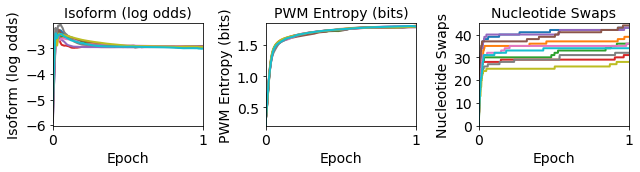

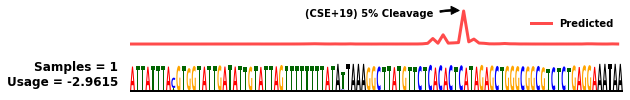

Optimizing objective 1...
Epoch 1/1
2000/2000 [==============================] - 73s 36ms/step - loss: 0.4662


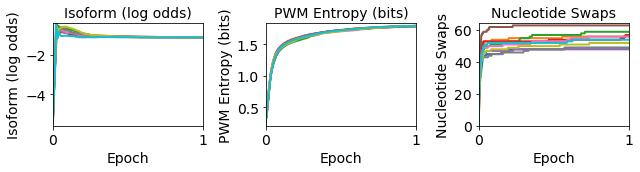

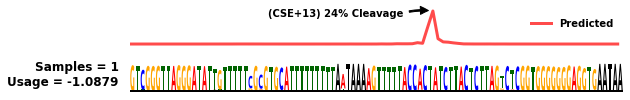

Optimizing objective 2...
Epoch 1/1
2000/2000 [==============================] - 64s 32ms/step - loss: 0.7116


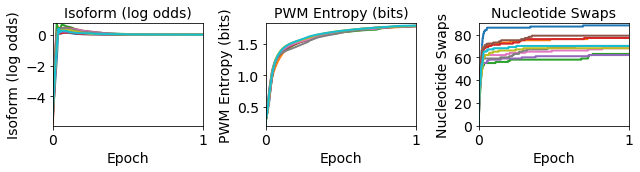

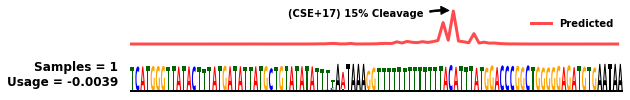

Optimizing objective 3...
Epoch 1/1
2000/2000 [==============================] - 56s 28ms/step - loss: 1.0756


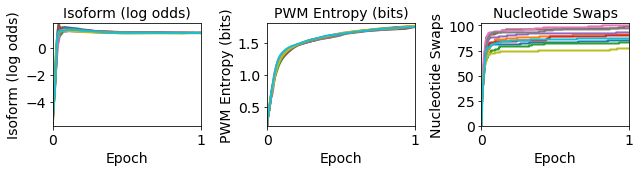

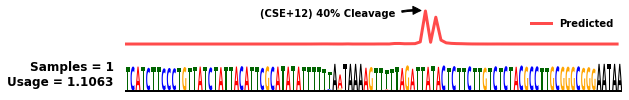

Optimizing objective 4...
Epoch 1/1
2000/2000 [==============================] - 61s 31ms/step - loss: 1.7734


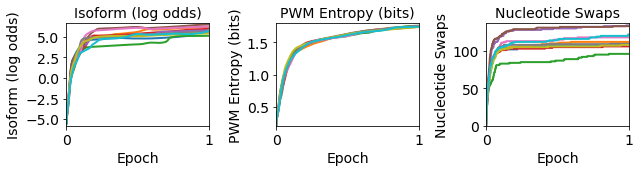

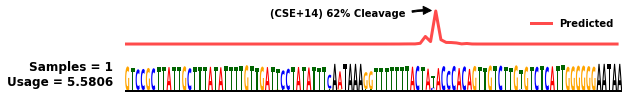

In [4]:
#Optimize target isoform proportions for the 'Alien1' (aka 'Simple') library

seq_template = 'ATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNANTAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAAGTCCTGCCCGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTGT'
library_context = 22

iso_objectives = [0.05, 0.25, 0.50, 0.75, 1.0]

#Run SeqProp Optimization

print("Running optimization experiment 'Alien1 Isoforms'")

#Number of PWMs to generate per objective
n_sequences = 10
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 1#10
#Number of steps (grad updates) per epoch
steps_per_epoch = 2000

sequence_templates = [
    seq_template
    for target_iso in iso_objectives
]

losses = [
    get_isoform_loss(
        target_iso,
        use_start=4,
        use_end=49,
        use_target_bits=1.8,
        cse_start=49,
        cse_end=55,
        cse_target_bits=1.9,
        dse_start=55,
        dse_end=100,
        dse_target_bits=1.8,
        entropy_weight=0.1,
        punish_up_c=0.001,
        punish_up_g=0.0001,
        punish_dn_g=0.00005,
        punish_up_aa=0.0025,
        punish_dn_aa=0.005,
    )
    for target_iso in iso_objectives
]

alien1_pwms, alien1_cuts = run_seqprop(sequence_templates, losses, library_context, n_sequences, n_samples, n_epochs, steps_per_epoch)



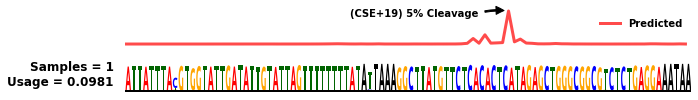

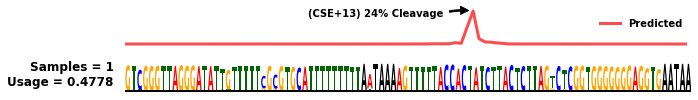

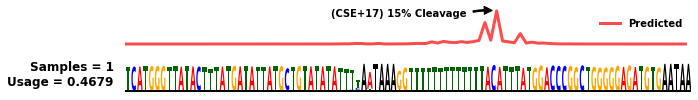

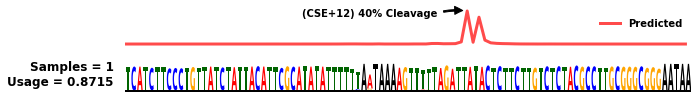

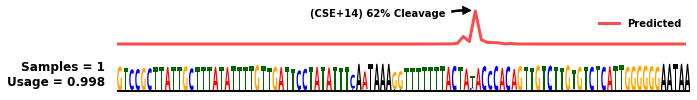

In [23]:
#Plot one PWM sequence logo per optimized objective (Experiment 'Alien1 Isoforms')

pwms = alien1_pwms
cuts = alien1_cuts

pwm_index = 1 #Chosen PWM index
for obj_index, sequence_template in enumerate(sequence_templates) :
    
    pwm = np.expand_dims(pwms[obj_index][pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cuts[obj_index][0, pwm_index, :], axis=0)
    iso = np.expand_dims(np.sum(cut[:, 60:95], axis=-1), axis=-1)

    plot_seqprop_logo(pwm, iso, cut, cse_start_pos=49, annotate_peaks='max', sequence_template=sequence_template, figsize=(10, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=49-40, plot_end=55+50)


Running optimization experiment 'Alien2 Isoforms'
Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 102s 51ms/step - loss: 0.3692


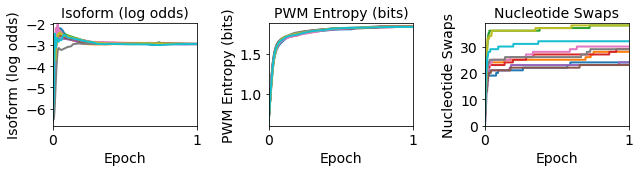

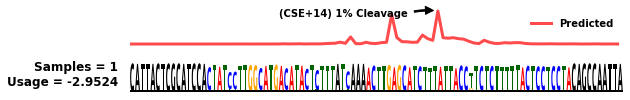

Optimizing objective 1...
Epoch 1/1
2000/2000 [==============================] - 88s 44ms/step - loss: 0.5423


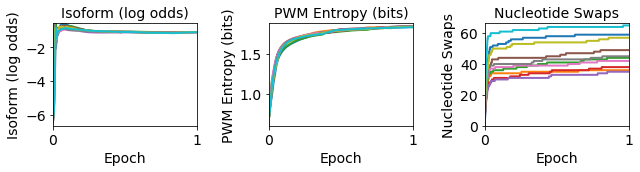

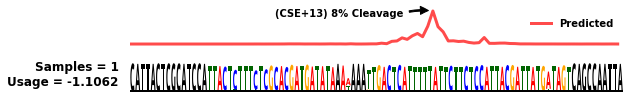

Optimizing objective 2...
Epoch 1/1
2000/2000 [==============================] - 93s 46ms/step - loss: 0.7826


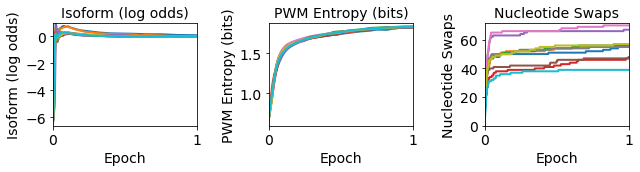

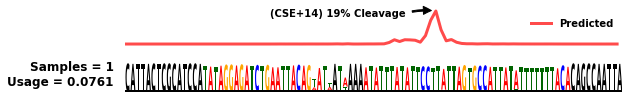

Optimizing objective 3...
Epoch 1/1
2000/2000 [==============================] - 96s 48ms/step - loss: 1.0569


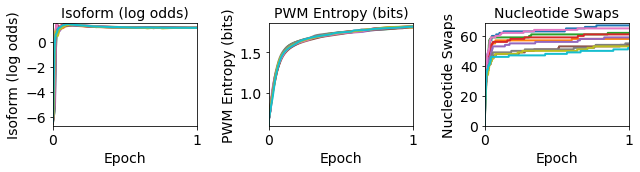

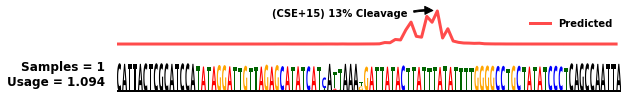

Optimizing objective 4...
Epoch 1/1
2000/2000 [==============================] - 94s 47ms/step - loss: 1.3801


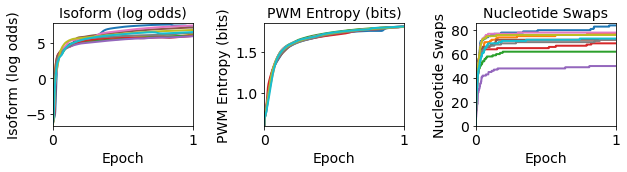

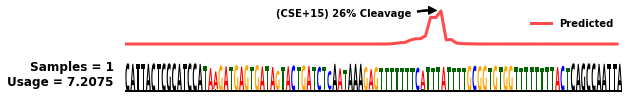

In [6]:
#Optimize target isoform proportions for the 'Alien2' (aka 'Doubledope') library

seq_template = 'XXXXXXXXXCATTACTCGCATCCANNNNNNNNNNNNNNNNNNNNNNNNNANNAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCAGCCAATTAAGCCTGTCGTCGTGGGTGTCGAAAATGAAATAAAACAAGTCAATTGCGTAGTTTATTCAGACGTACCCCGTGGACCTACG'
library_context = 20

iso_objectives = [0.05, 0.25, 0.50, 0.75, 1.0]

#Run SeqProp Optimization

print("Running optimization experiment 'Alien2 Isoforms'")

#Number of PWMs to generate per objective
n_sequences = 10
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 1#10
#Number of steps (grad updates) per epoch
steps_per_epoch = 2000

sequence_templates = [
    seq_template
    for target_iso in iso_objectives
]

losses = [
    get_isoform_loss(
        target_iso,
        use_start=24,
        use_end=49,
        use_target_bits=1.8,
        cse_start=49,
        cse_end=55,
        cse_target_bits=1.9,
        dse_start=55,
        dse_end=95,
        dse_target_bits=1.8,
        entropy_weight=0.1,
        punish_up_c=0.001,
        punish_up_g=0.0001,
        punish_dn_g=0.00005,
        punish_up_aa=0.0025,
        punish_dn_aa=0.005,
    )
    for target_iso in iso_objectives
]

alien2_pwms, alien2_cuts = run_seqprop(sequence_templates, losses, library_context, n_sequences, n_samples, n_epochs, steps_per_epoch)



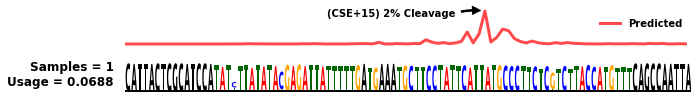

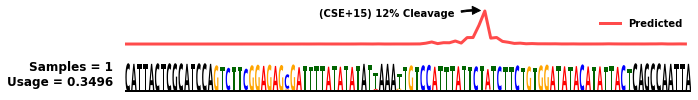

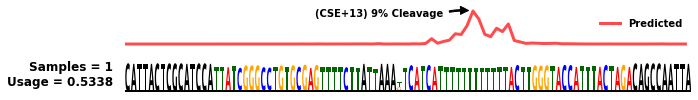

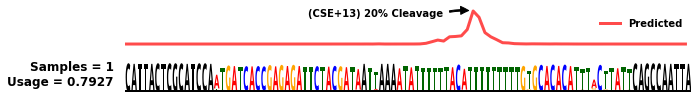

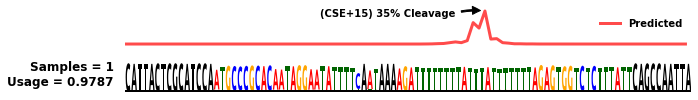

In [20]:
#Plot one PWM sequence logo per optimized objective (Experiment 'Alien2 Isoforms')

pwms = alien2_pwms
cuts = alien2_cuts

pwm_index = 1 #Chosen PWM index
for obj_index, sequence_template in enumerate(sequence_templates) :
    
    pwm = np.expand_dims(pwms[obj_index][pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cuts[obj_index][0, pwm_index, :], axis=0)
    iso = np.expand_dims(np.sum(cut[:, 60:95], axis=-1), axis=-1)

    plot_seqprop_logo(pwm, iso, cut, cse_start_pos=49, annotate_peaks='max', sequence_template=sequence_template, figsize=(10, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=49-40, plot_end=55+50)


Running optimization experiment 'TOMM5 Isoforms'
Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 84s 42ms/step - loss: 0.4896


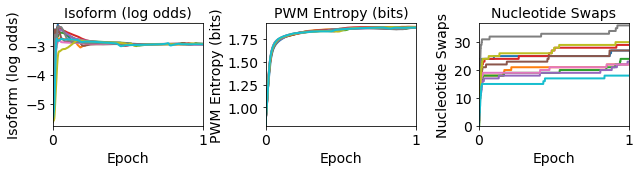

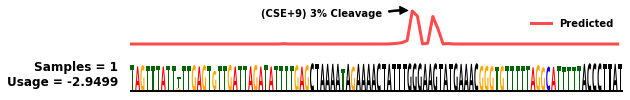

Optimizing objective 1...
Epoch 1/1
2000/2000 [==============================] - 100s 50ms/step - loss: 0.6923


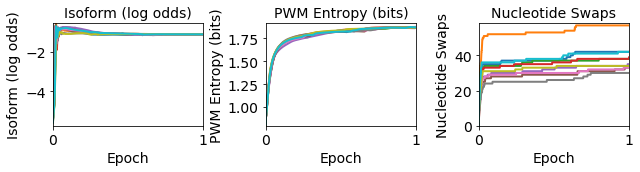

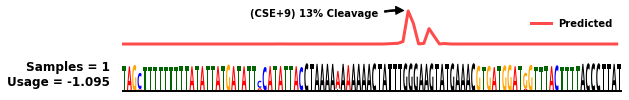

Optimizing objective 2...
Epoch 1/1
2000/2000 [==============================] - 101s 50ms/step - loss: 0.9412


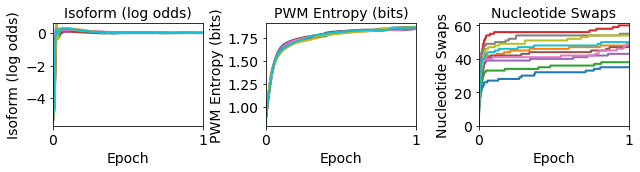

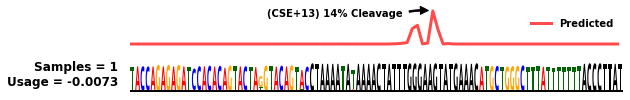

Optimizing objective 3...
Epoch 1/1
2000/2000 [==============================] - 103s 51ms/step - loss: 1.1283


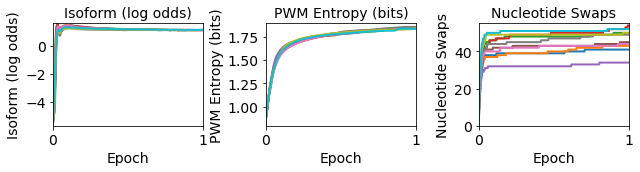

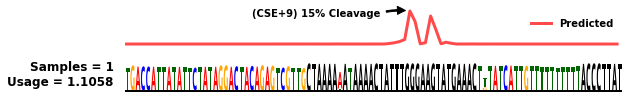

Optimizing objective 4...
Epoch 1/1
2000/2000 [==============================] - 95s 47ms/step - loss: 1.5391


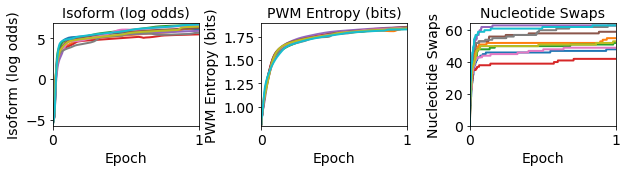

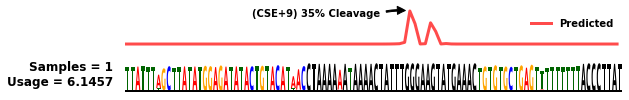

In [8]:
#Optimize target isoform proportions for the 'TOMM5' library

seq_template = 'TGCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCTAAAANANAAAACTATTTGGGAAGTATGAAACNNNNNNNNNNNNNNNNNNNNACCCTTATCCCTGTGACGTTTGGCCTCTGACAATACTGGTATAATTGTAAATAATGTCAAACTCCGTTTTCTAGCAAGTATTAAGGGA'
library_context = 11

iso_objectives = [0.05, 0.25, 0.50, 0.75, 1.0]

#Run SeqProp Optimization

print("Running optimization experiment 'TOMM5 Isoforms'")

#Number of PWMs to generate per objective
n_sequences = 10
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 1#10
#Number of steps (grad updates) per epoch
steps_per_epoch = 2000

sequence_templates = [
    seq_template
    for target_iso in iso_objectives
]

losses = [
    get_isoform_loss(
        target_iso,
        use_start=4,
        use_end=44,
        use_target_bits=1.8,
        cse_start=49,
        cse_end=55,
        cse_target_bits=1.9,
        dse_start=77,
        dse_end=97,
        dse_target_bits=1.8,
        entropy_weight=0.1,
        punish_up_c=0.001,
        punish_up_g=0.0001,
        punish_dn_g=0.00005,
        punish_up_aa=0.0025,
        punish_dn_aa=0.005,
    )
    for target_iso in iso_objectives
]

tomm5_pwms, tomm5_cuts = run_seqprop(sequence_templates, losses, library_context, n_sequences, n_samples, n_epochs, steps_per_epoch)



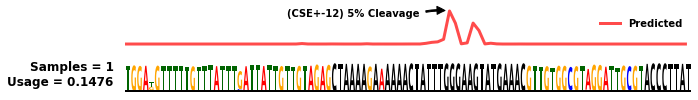

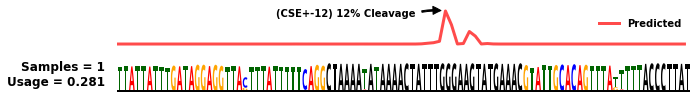

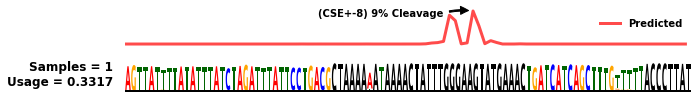

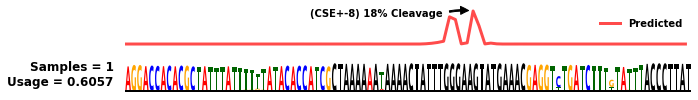

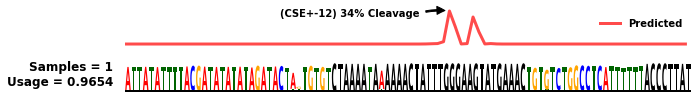

In [14]:
#Plot one PWM sequence logo per optimized objective (Experiment 'TOMM5 Isoforms')

pwms = tomm5_pwms
cuts = tomm5_cuts

pwm_index = 1 #Chosen PWM index
for obj_index, sequence_template in enumerate(sequence_templates) :
    
    pwm = np.expand_dims(pwms[obj_index][pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cuts[obj_index][0, pwm_index, :], axis=0)
    iso = np.expand_dims(np.sum(cut[:, 60:95], axis=-1), axis=-1)

    plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=sequence_template, figsize=(10, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=49-40, plot_end=55+50)


Running optimization experiment 'Max Isoforms of All libraries'
Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 107s 54ms/step - loss: 1.7219


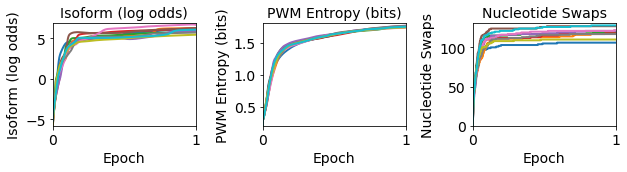

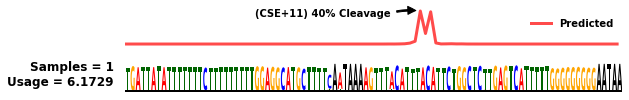

Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 104s 52ms/step - loss: 1.3854


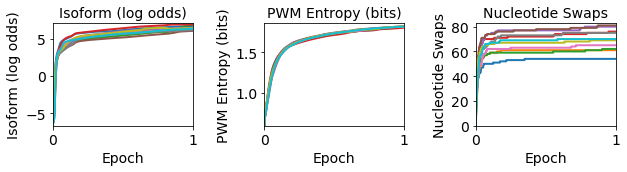

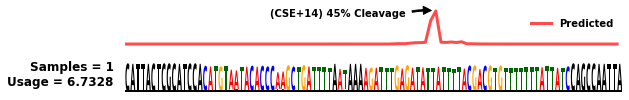

Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 110s 55ms/step - loss: 1.5264


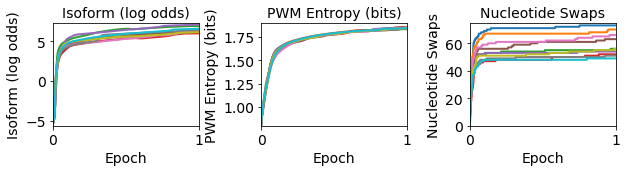

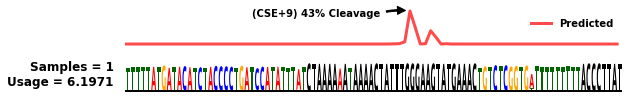

Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 104s 52ms/step - loss: 0.4539


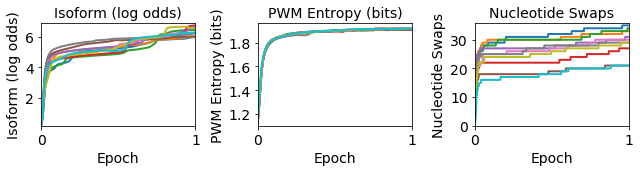

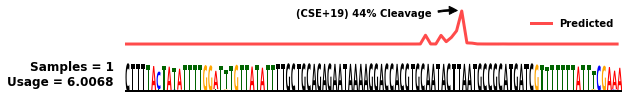

Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 105s 52ms/step - loss: 1.0443


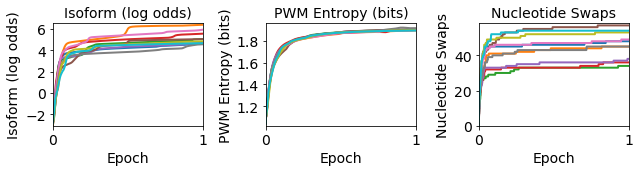

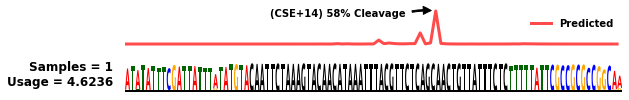

Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 107s 54ms/step - loss: 0.5318


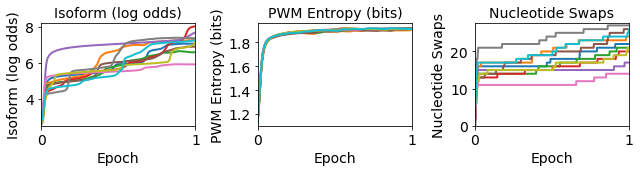

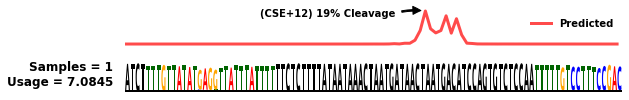

Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 93s 47ms/step - loss: 0.5572


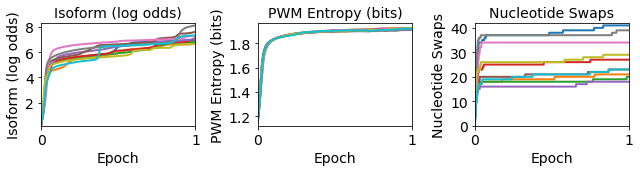

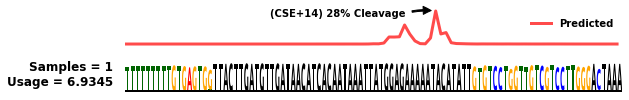

Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 91s 46ms/step - loss: 1.2977


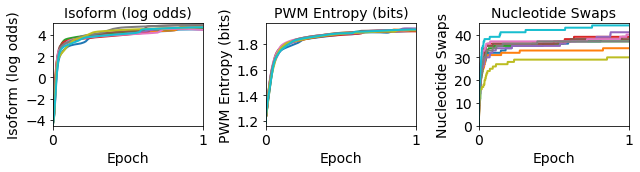

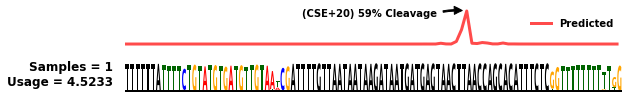

Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 95s 47ms/step - loss: 0.4566


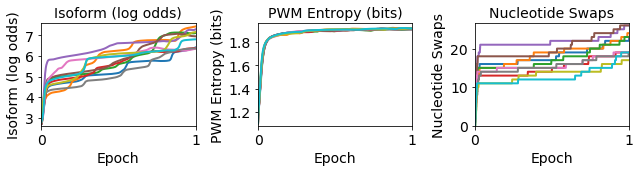

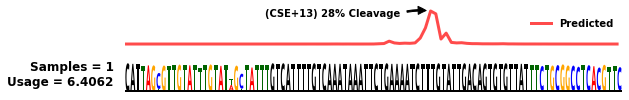

In [10]:
#Maximize isoform proportions for all minigene libraries

seq_templates = [
    'ATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNANTAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAAGTCCTGCCCGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTGT',
    'XXXXXXXXXCATTACTCGCATCCANNNNNNNNNNNNNNNNNNNNNNNNNANNAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCAGCCAATTAAGCCTGTCGTCGTGGGTGTCGAAAATGAAATAAAACAAGTCAATTGCGTAGTTTATTCAGACGTACCCCGTGGACCTACG',
    'TGCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCTAAAANANAAAACTATTTGGGAAGTATGAAACNNNNNNNNNNNNNNNNNNNNACCCTTATCCCTGTGACGTTTGGCCTCTGACAATACTGGTATAATTGTAAATAATGTCAAACTCCGTTTTCTAGCAAGTATTAAGGGA',
    'ATCTCTGAGCTTTNNNNNNNNNNNNNNNNNNNNNNNNNTTGCTGCAGAGAATAAAAGGACCACGTGCAATACTTAATGCCGCATGATCNNNNNNNNNNNNNNNNNNNNNNNNNGGCTCTTTTGACAGCCTTTGGCGTCTGTAGAATAAATGCTGTGGCTCCTGCTGGCTGCTGTGGTGTTCACCX',
    'TGCATTTGNNNNNNNNNNNNNNNNNNNNNNNNNCAATTCTAAAGTACAACATAAATTTACGTTCTCAGCAACTGTTATTTCTCNNNNNNNNNNNNNNNNNNNNNNNNNAATATACATTCAGTTATTAAGAAATAAACTGCTTTCTTAATACATACTGTGCATTATAATTGGAGAAATAGAATATX',
    'TCTTCTGAAATCTNNNNNNNNNNNNNNNNNNNNNNNNNTTCTCTTTTATAATAAACTAATGATAACTAATGACATCCAGTGTCTCCAANNNNNNNNNNNNNNNNNNNNNNNNNCACTTCCAAATAAAAATATGTAAATGAGTGGTTAATCTTTAGTTATTTTAAGATGATTTTAGGGTTTTGCTX',
    'ANNNNNNNNNNNNNNNNNNNNNNNNNTTACTTGATGTTGATAACATCACAATAAATTATGGAGAAAAATACATATTNNNNNNNNNNNNNNNNNNNNNNNANTAAAGTGTTTTCTTTTAAATCAACTCTAAATAGCTCCATTCTCATAGTCACTAGTCAGACCGCTCGCGCACTACTCAGCGACCX',
    'CGATCTTCTTTTTTTANNNNNNNNNNNNNNNNNNNNNNNNNATTTTGTTAATAATAAGATAATGATGAGTAACTTAACCAGCACATTTCTCNNNNNNNNNNNNNNNNNNNNNNNNNGTTTTCTGATGACATAATAAAGACAGATCATTTCAGAATCTGGCCCTTGTGCAGGGGAGGAGGGAGGCX',
    'CTTGAATTTCATNNNNNNNNNNNNNNNNNNNNNNNNNGTCATTTTGTCAAATAAATTCTGAAAATCTTTGTATTGACAGTGTGTTATNNNNNNNNNNNNNNNNNNNNNNNNNAGTGCTCAATAAAAAGAATAAAGAGGAAACAGCACTGGATCTATACCTATACAAAACAAGCTACCAGCGCTCX'
]

region_start_ends = [
    [[4, 49], [49, 55], [55, 100]],
    [[24, 49], [49, 55], [55, 95]],
    [[4, 44], [49, 55], [77, 97]],
    [[13, 13 + 25], [49, 55], [13 + 75, 13 + 100]],
    [[8, 8 + 25], [49, 55], [8 + 75, 8 + 100]],
    [[13, 13 + 25], [49, 55], [13 + 75, 13 + 100]],
    [[1, 1 + 25], [49, 55], [1 + 75, 1 + 100]],
    [[16, 16 + 25], [49, 55], [16 + 75, 16 + 100]],
    [[12, 12 + 25], [49, 55], [12 + 75, 12 + 100]]
]

libraries = [
    'Alien1',
    'Alien2',
    'TOMM5',
    'AARS',
    'ATR',
    'HSPE1',
    'SNHG6',
    'SOX13',
    'WHAMMP2'
]

library_contexts = [
    22,
    20,
    11,
    30,
    31,
    32,
    33,
    34,
    35
]

iso_objectives = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Run SeqProp Optimization

print("Running optimization experiment 'Max Isoforms of All libraries'")

#Number of PWMs to generate per objective
n_sequences = 10
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 1#10
#Number of steps (grad updates) per epoch
steps_per_epoch = 2000

sequence_templates = [
    seq_template
    for target_iso in iso_objectives
]

losses = [
    get_isoform_loss(
        target_iso,
        use_start=region[0][0],
        use_end=region[0][1],
        use_target_bits=1.8,
        cse_start=region[1][0],
        cse_end=region[1][1],
        cse_target_bits=1.9,
        dse_start=region[2][0],
        dse_end=region[2][1],
        dse_target_bits=1.8,
        entropy_weight=0.1,
        punish_up_c=0.001,
        punish_up_g=0.0001,
        punish_dn_g=0.00005,
        punish_up_aa=0.0025,
        punish_dn_aa=0.005,
    )
    for target_iso, region in zip(iso_objectives, region_start_ends)
]

max_pwms = []
max_cuts = []

for seq_template, library_context, loss in zip(seq_templates, library_contexts, losses) :

    pwm, cut = run_seqprop([seq_template], [loss], library_context, n_sequences, n_samples, n_epochs, steps_per_epoch)

    max_pwms.extend(pwm)
    max_cuts.extend(cut)


Library = Alien1


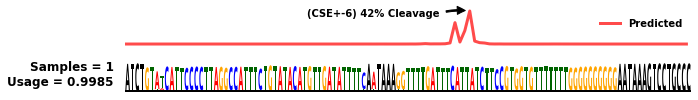

Library = Alien2


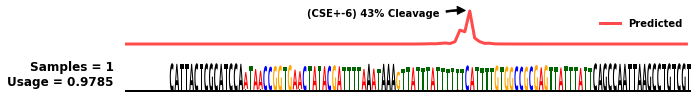

Library = TOMM5


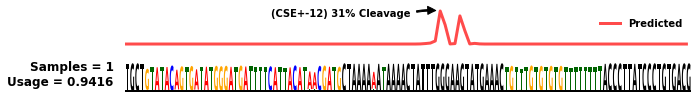

Library = AARS


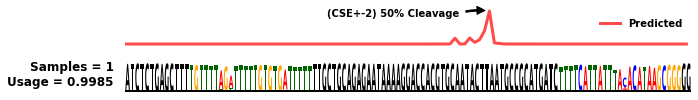

Library = ATR


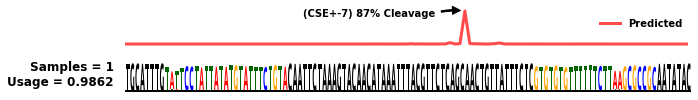

Library = HSPE1


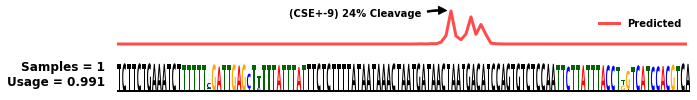

Library = SNHG6


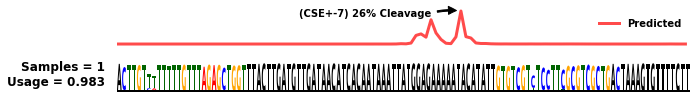

Library = SOX13


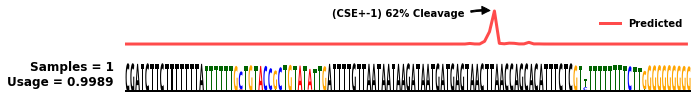

Library = WHAMMP2


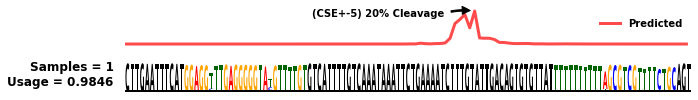

In [11]:
#Plot one PWM sequence logo per optimized objective (Experiment 'Max Isoforms of 6 libraries')

pwms = max_pwms
cuts = max_cuts

pwm_index = 1 #Chosen PWM index
for obj_index, library in enumerate(libraries) :
    
    print("Library = " + str(library))
    
    pwm = np.expand_dims(pwms[obj_index][pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cuts[obj_index][0, pwm_index, :], axis=0)
    iso = np.expand_dims(np.sum(cut[:, 60:95], axis=-1), axis=-1)

    plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=seq_templates[obj_index], figsize=(10, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=0, plot_end=115)
